In [12]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from pyobsbox import ObsBoxGenerator 
from pyobsbox.utils import rolling_window

from paths import metadata_folder

# Logging

Set the logging level to debug.

In [13]:
logging.getLogger("pyobsbox").setLevel(logging.DEBUG)

# Metadata

Let's load the metadata.

In [14]:
list(metadata_folder.glob("metadata_*"))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B2H_Inst_23528.h5'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_32.h5'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_1024.h5'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1V_Inst_51335.h5'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B2V_Inst_60652.h5')]

In [15]:
metadata = metadata_folder / "metadata_B1H_Inst_1024.h5"

In [16]:
meta_df = pd.read_hdf(metadata)

In [17]:
meta_df.head()

,type,fill,beam,plane,q,date_time,file,n_bunches,bunch_index,bunch_number,ts_length
0,Inst,6817,1,h,7,2018-06-18 00:26:52,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6817/...,12,0.0,0.0,65536
1,Inst,6817,1,h,7,2018-06-18 00:26:52,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6817/...,12,550.0,1.0,65536
2,Inst,6817,1,h,7,2018-06-18 00:26:52,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6817/...,12,650.0,2.0,65536
3,Inst,6817,1,h,7,2018-06-18 00:26:52,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6817/...,12,750.0,3.0,65536
4,Inst,6817,1,h,7,2018-06-18 00:26:52,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6817/...,12,850.0,4.0,65536


# Generator

Create the generator.

In [28]:
generator = ObsBoxGenerator(meta_df, n_bunches=1, sequence_length=2048, shuffle=False, normalization="min_max",
                            rolling_window=129)

May/12 22:14:35 pyobsbox.generator DEBUG: Normalization method: <bound method ObsBoxGenerator._min_max of <pyobsbox.generator.ObsBoxGenerator object at 0x7fb6f7cfcc88>>
May/12 22:14:35 pyobsbox.generator DEBUG: Normalization kwargs: {}
May/12 22:14:35 pyobsbox.generator INFO: Completed 'batch_size': 31
May/12 22:14:35 pyobsbox.generator INFO: metadata_path: None
May/12 22:14:35 pyobsbox.generator INFO: ts_length: 63488
May/12 22:14:35 pyobsbox.generator INFO: shuffle: False
May/12 22:14:35 pyobsbox.generator INFO: seed: None
May/12 22:14:35 pyobsbox.generator INFO: batch_size: 31
May/12 22:14:35 pyobsbox.generator INFO: sequence_length: 2048
May/12 22:14:35 pyobsbox.generator INFO: n_bunches: 1
May/12 22:14:35 pyobsbox.generator INFO: __len__: 369627
May/12 22:14:35 pyobsbox.generator INFO: fetched_log_folder: None
May/12 22:14:35 pyobsbox.generator INFO: fetched_log_prefix: 
May/12 22:14:35 pyobsbox.generator INFO: normalization: min_max
May/12 22:14:35 pyobsbox.generator INFO: normal

# Preprocessing steps

In [29]:
subset = generator._create_subset(0)
subset

May/12 22:14:37 pyobsbox.generator DEBUG: Subset indices: [0]


,type,fill,beam,plane,q,date_time,file,n_bunches,bunch_index,bunch_number,ts_length
0,Inst,6817,1,h,7,2018-06-18 00:26:52,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6817/...,12,0.0,0.0,65536


In [30]:
raw = generator._load(subset)
raw.shape

May/12 22:14:39 pyobsbox.generator DEBUG: Opening 1 files.
May/12 22:14:39 pyobsbox.generator DEBUG: Opening /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6817/instability_data/06817_Inst_B1H_Q7_20180618_00h26m52s.h5
May/12 22:14:39 pyobsbox.generator DEBUG: Loading 1 bunches.
May/12 22:14:39 pyobsbox.generator DEBUG: Reorder index: [0]


(1, 65536)

In [21]:
# raw = np.expand_dims(raw, -1)

In [31]:
from pyobsbox.utils import rolling_avg, rolling_std
# rolling avg/std
out = []
avg = rolling_avg(raw, 129)
out.append(avg)
std = rolling_std(raw, 129)
out.append(std)

rolling = np.stack(out, axis=-1)

In [32]:
split = generator._split(rolling.copy())
split.shape

May/12 22:14:42 pyobsbox.generator DEBUG: Pre-split: (1, 65408, 2)
May/12 22:14:42 pyobsbox.generator DEBUG: Number of splits: 31
May/12 22:14:42 pyobsbox.generator DEBUG: Post-split: (31, 2048, 2)


(31, 2048, 2)

In [33]:
znorm = generator.normalization_method(split.copy().astype(np.float64))
znorm.shape

(31, 2048, 2)

The `generator.__getitem__` method does all these steps.

In [34]:
znorm.shape

(31, 2048, 2)

In [14]:
np.allclose(znorm, generator[0][0])

May/11 21:43:21 pyobsbox.generator DEBUG: Started fetching index 0.
May/11 21:43:21 pyobsbox.generator DEBUG: Subset indices: [0]
May/11 21:43:21 pyobsbox.generator DEBUG: Opening 1 files.
May/11 21:43:21 pyobsbox.generator DEBUG: Opening /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6817/instability_data/06817_Inst_B1H_Q7_20180618_00h26m52s.h5
May/11 21:43:21 pyobsbox.generator DEBUG: Loading 1 bunches.
May/11 21:43:21 pyobsbox.generator DEBUG: Reorder index: [0]
May/11 21:43:21 pyobsbox.generator DEBUG: Pre-split: (1, 65536, 1)
May/11 21:43:21 pyobsbox.generator DEBUG: Number of splits: 32
May/11 21:43:21 pyobsbox.generator DEBUG: Post-split: (32, 2048, 1)
May/11 21:43:21 pyobsbox.generator DEBUG: Normalization post split.
May/11 21:43:21 pyobsbox.generator DEBUG: Pre norm data.shape (32, 2048, 1)
May/11 21:43:21 pyobsbox.generator DEBUG: Post norm data.shape (32, 2048, 1)
May/11 21:43:21 pyobsbox.generator DEBUG: Data final shape: (32, 2048, 1)
May/11 21:43:21 pyobsbox.generator DEBUG: F

True

In [15]:
np.count_nonzero

<function numpy.count_nonzero(a, axis=None)>

# Vizualize raw data

In [56]:
raw.shape

(1, 65536)

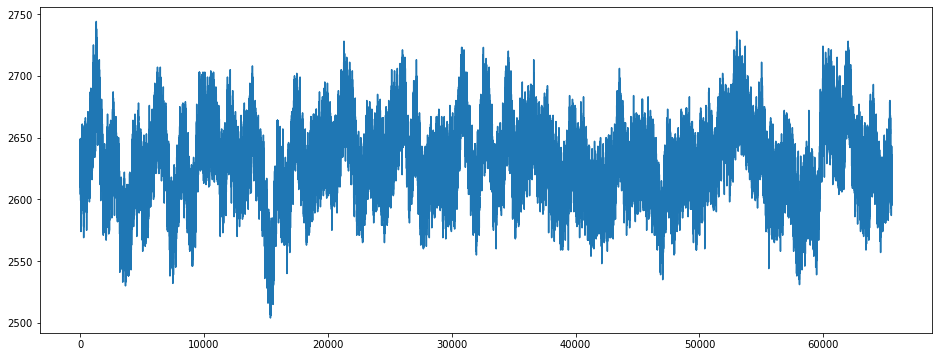

In [16]:
fig = plt.figure(figsize=(16, 6))
plt.plot(raw[0, :]);

# Vizualize split data

All the splits concatenated, make sure we are not missing anything

(0.0, 65536.0)

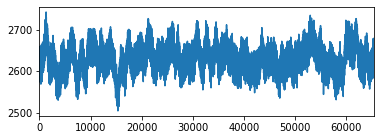

In [65]:
fig = plt.figure(figsize=(6, 2))
plt.plot(np.vstack(split));
plt.xlim([0, raw.shape[1]])

The splits.

In [40]:
rolling.shape

(1, 65408, 2)

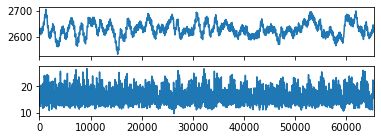

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(6, 2), sharex=True)
for i in range(2):
    ax[i].plot(rolling.squeeze()[:, i].T)
    ax[i].set_xlim([0, raw.shape[1]])
# plt.plot()

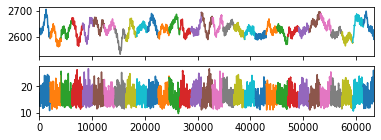

In [53]:
fig, axes = plt.subplots(2, 1, figsize=(6, 2), sharex=True)
for i, data_split in enumerate(split[:, :, 0]):
    axes[0].plot(range(i * generator.sequence_length, (i + 1) * generator.sequence_length), data_split)
    axes[0].set_xlim([0, raw.shape[1] - 2048])
for i, data_split in enumerate(split[:, :, 1]):
    axes[1].plot(range(i * generator.sequence_length, (i + 1) * generator.sequence_length), data_split)
    axes[1].set_xlim([0, raw.shape[1] - 2048])

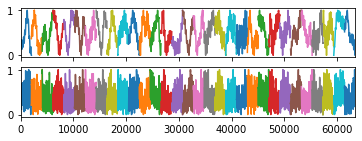

In [55]:
fig, axes = plt.subplots(2, 1, figsize=(6, 2), sharex=True)
for i, znorm_split in enumerate(znorm[:, :, 0]):
    axes[0].plot(range(i * generator.sequence_length, (i + 1) * generator.sequence_length), znorm_split)
    axes[0].set_xlim([0, raw.shape[1] - 2048])
for i, znorm_split in enumerate(znorm[:, :, 1]):
    axes[1].plot(range(i * generator.sequence_length, (i + 1) * generator.sequence_length), znorm_split)
    axes[1].set_xlim([0, raw.shape[1] - 2048])
# plt.xlim([0, raw.shape[1]])

(0.0, 65536.0)

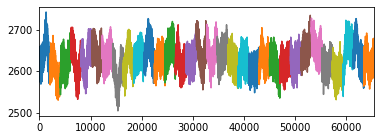

In [64]:
fig = plt.figure(figsize=(6, 2))
for i, data_split in enumerate(split):
    plt.plot(range(i * generator.sequence_length, (i + 1) * generator.sequence_length), data_split)
plt.xlim([0, raw.shape[1]])

(0.0, 65536.0)

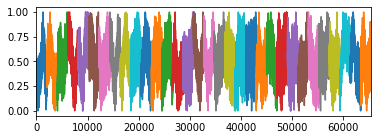

In [66]:
fig = plt.figure(figsize=(6, 2))
for i, znorm_split in enumerate(znorm):
    plt.plot(range(i * generator.sequence_length, (i + 1) * generator.sequence_length), znorm_split)
plt.xlim([0, raw.shape[1]])

# Vizualize znorm data

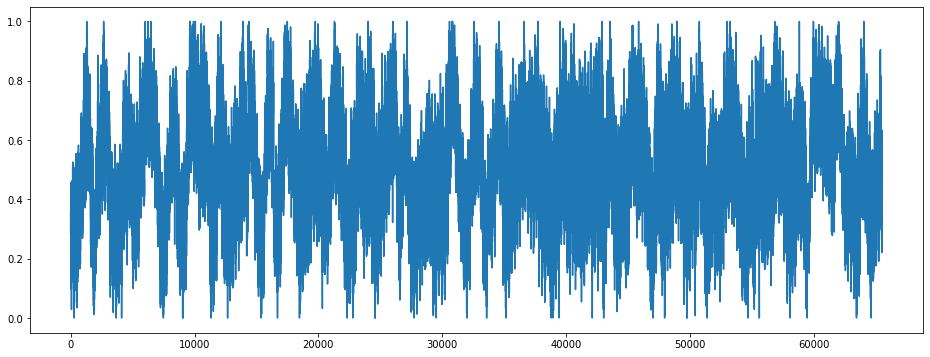

In [20]:
fig = plt.figure(figsize=(16, 6))
plt.plot(np.hstack(znorm.squeeze()));

Each split of the timeseries should have a mean 0 and std 1.

In [21]:
znorm.mean(axis=1)

array([[0.42739397],
       [0.46126095],
       [0.52361858],
       [0.51234096],
       [0.53846848],
       [0.55760272],
       [0.47468014],
       [0.54148902],
       [0.52812138],
       [0.51239211],
       [0.5008024 ],
       [0.50445964],
       [0.52323432],
       [0.42108673],
       [0.45565586],
       [0.53106689],
       [0.51413879],
       [0.49188443],
       [0.50580063],
       [0.50503125],
       [0.50698686],
       [0.45408387],
       [0.54287967],
       [0.54099101],
       [0.50191958],
       [0.45410491],
       [0.45451086],
       [0.55417633],
       [0.46229499],
       [0.61618982],
       [0.51140093],
       [0.46892952]])

In [22]:
znorm.std(axis=1)

array([[0.18762704],
       [0.18870215],
       [0.16466703],
       [0.20597345],
       [0.2172094 ],
       [0.18512858],
       [0.16118432],
       [0.20392052],
       [0.18651034],
       [0.17112259],
       [0.17434496],
       [0.18048692],
       [0.1773407 ],
       [0.16694208],
       [0.17319863],
       [0.20165469],
       [0.17826855],
       [0.1571304 ],
       [0.17130734],
       [0.17016371],
       [0.16712567],
       [0.16540466],
       [0.18574635],
       [0.17260359],
       [0.16039961],
       [0.16410822],
       [0.18141392],
       [0.15610605],
       [0.14577884],
       [0.18018178],
       [0.18422204],
       [0.16628806]])

# Different normalization methods

Increasing the logging level.

In [23]:
logging.getLogger("pyobsbox").setLevel(logging.WARNING)

* znorm (post-split):

Each sequence is individually znorm-ed, i.e. mean 0 and std 1.

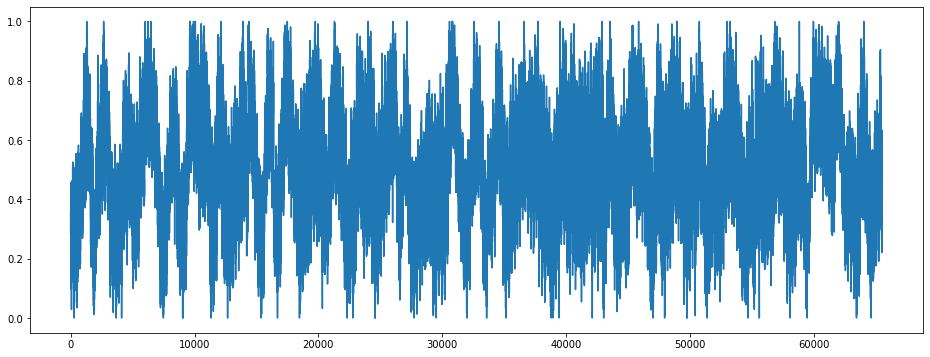

In [24]:
fig = plt.figure(figsize=(16, 6))
plt.plot(np.hstack(znorm.squeeze()));

* znorm pre-split:

The entire time series is znorm-ed, before the splitting occurs

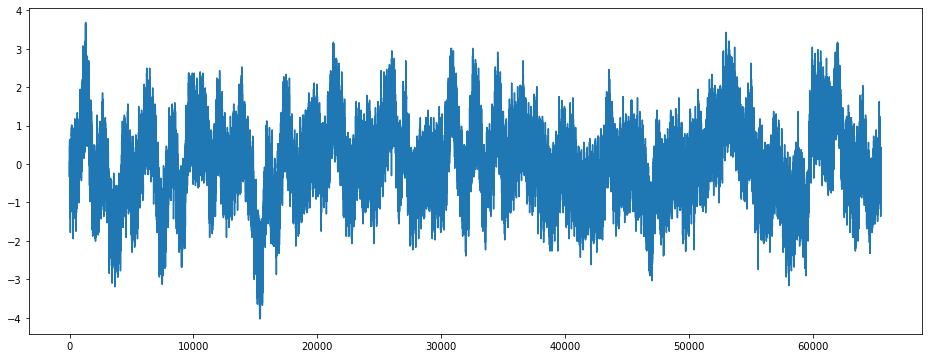

In [25]:
generator = ObsBoxGenerator(meta_df,
                            n_bunches=1,
                            sequence_length=2048,
                            shuffle=False,
                            normalization='znorm',
                            normalization_pre_split=True)
fig = plt.figure(figsize=(16, 6))
plt.plot(np.hstack(generator[0][0].squeeze()));

* center_scale post-split:

Similar to znorm, but instead of computing the standard deviation a constant rescaling factor is used for all the data.

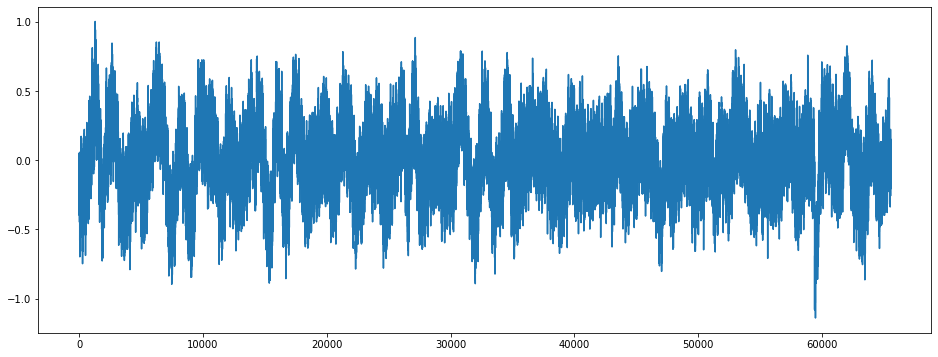

In [26]:
generator = ObsBoxGenerator(meta_df,
                            n_bunches=1,
                            sequence_length=2048,
                            shuffle=False,
                            normalization='center_scale',
                            normalization_pre_split=False)
fig = plt.figure(figsize=(16, 6))
plt.plot(np.hstack(generator[0][0].squeeze()));

* center_scale pre-split:

Same thing, but the mean of the entire time seires is substracted, instead of it being for each sequence.

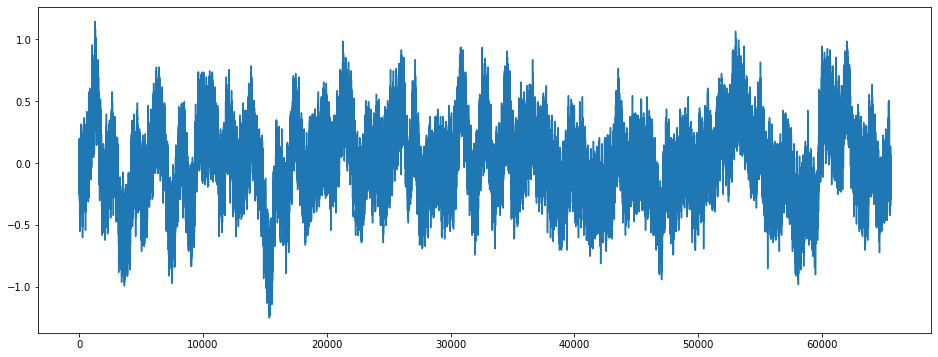

In [27]:
generator = ObsBoxGenerator(meta_df,
                            n_bunches=1,
                            sequence_length=2048,
                            shuffle=False,
                            normalization='center_scale',
                            normalization_pre_split=True)
fig = plt.figure(figsize=(16, 6))
plt.plot(np.hstack(generator[0][0].squeeze()));

* min_max:

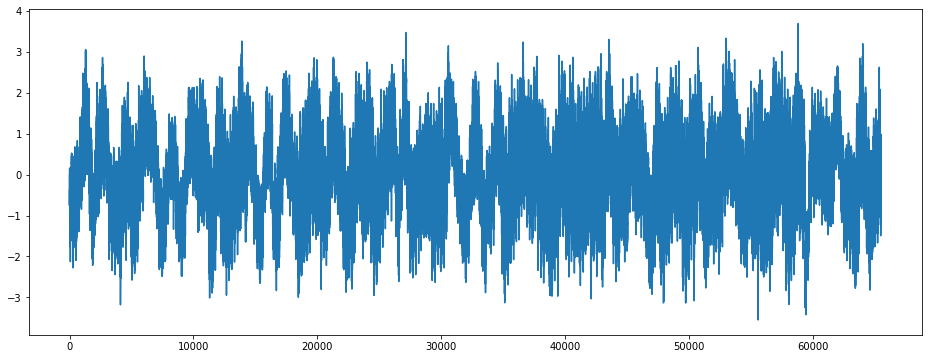

In [28]:
generator = ObsBoxGenerator(meta_df,
                            n_bunches=1,
                            sequence_length=2048,
                            shuffle=False,
                            normalization='znorm',
                            normalization_pre_split=False,
                            abs_diff=False,
                            diff=False)
fig = plt.figure(figsize=(16, 6))
plt.plot(np.hstack(generator[0][0].squeeze()));

# Rolling metrics

In [29]:
logging.getLogger("pyobsbox").setLevel(logging.DEBUG)

* Raw data

May/11 21:43:25 pyobsbox.generator DEBUG: Normalization method: <function ObsBoxGenerator.__init__.<locals>.<lambda> at 0x7fc5e984dea0>
May/11 21:43:25 pyobsbox.generator DEBUG: Normalization kwargs: {}
May/11 21:43:25 pyobsbox.generator DEBUG: Shuffling metadata, seed 42
May/11 21:43:26 pyobsbox.generator INFO: Completed 'batch_size': 62
May/11 21:43:26 pyobsbox.generator INFO: metadata_path: None
May/11 21:43:26 pyobsbox.generator INFO: ts_length: 63488
May/11 21:43:26 pyobsbox.generator INFO: shuffle: True
May/11 21:43:26 pyobsbox.generator INFO: seed: 42
May/11 21:43:26 pyobsbox.generator INFO: batch_size: 62
May/11 21:43:26 pyobsbox.generator INFO: sequence_length: 2048
May/11 21:43:26 pyobsbox.generator INFO: n_bunches: 2
May/11 21:43:26 pyobsbox.generator INFO: __len__: 184814
May/11 21:43:26 pyobsbox.generator INFO: fetched_log_folder: None
May/11 21:43:26 pyobsbox.generator INFO: fetched_log_prefix: 
May/11 21:43:26 pyobsbox.generator INFO: normalization: raw
May/11 21:43:26 p

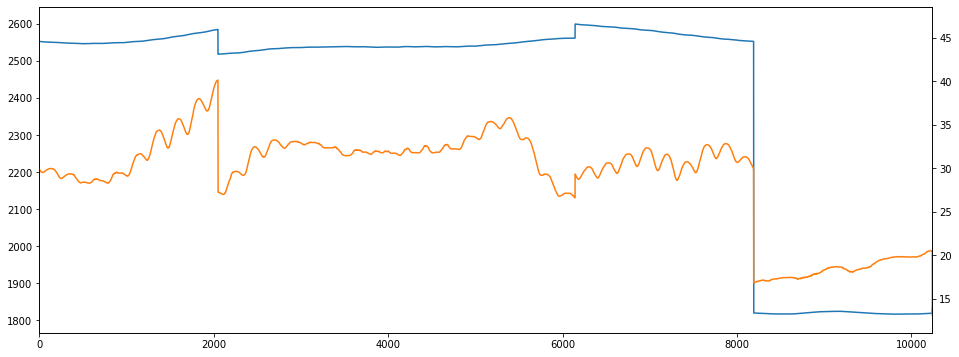

In [30]:
generator = ObsBoxGenerator(meta_df,
                            n_bunches=2,
                            sequence_length=2048,
                            shuffle=True,
                            seed=42,
                            normalization='raw',
                            normalization_pre_split=False,
                            abs_diff=False,
                            diff=False,
                            rolling_avg=True,
                            rolling_std=True,
                            rolling_window=2048 + 1)
data = generator[0][0]
fig, ax = plt.subplots(figsize=(16, 6))
ax2 = ax.twinx()
ax.plot(np.vstack(data)[:, 0], color='tab:blue')
ax2.plot(np.vstack(data)[:, 1], color='tab:orange')
plt.xlim(0, 2048*5);

* Using min max norm:

May/11 21:43:26 pyobsbox.generator DEBUG: Normalization method: <bound method ObsBoxGenerator._min_max of <pyobsbox.generator.ObsBoxGenerator object at 0x7fc5e9769908>>
May/11 21:43:26 pyobsbox.generator DEBUG: Normalization kwargs: {}
May/11 21:43:26 pyobsbox.generator DEBUG: Shuffling metadata, seed 42
May/11 21:43:26 pyobsbox.generator INFO: Completed 'batch_size': 62
May/11 21:43:26 pyobsbox.generator INFO: metadata_path: None
May/11 21:43:26 pyobsbox.generator INFO: ts_length: 63488
May/11 21:43:26 pyobsbox.generator INFO: shuffle: True
May/11 21:43:26 pyobsbox.generator INFO: seed: 42
May/11 21:43:26 pyobsbox.generator INFO: batch_size: 62
May/11 21:43:26 pyobsbox.generator INFO: sequence_length: 2048
May/11 21:43:26 pyobsbox.generator INFO: n_bunches: 2
May/11 21:43:26 pyobsbox.generator INFO: __len__: 184814
May/11 21:43:26 pyobsbox.generator INFO: fetched_log_folder: None
May/11 21:43:26 pyobsbox.generator INFO: fetched_log_prefix: 
May/11 21:43:26 pyobsbox.generator INFO: nor

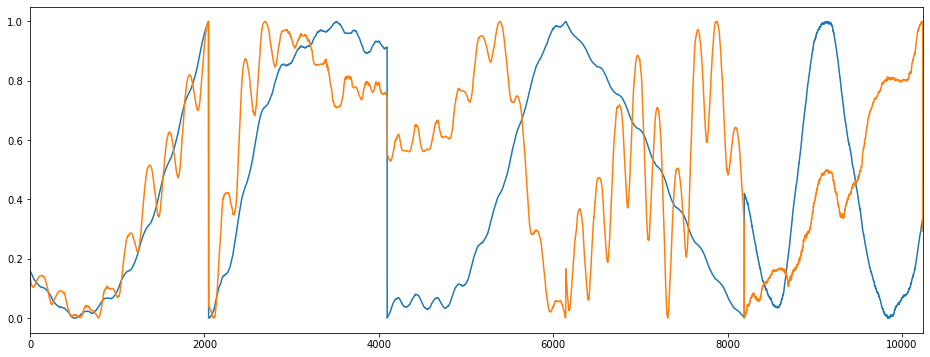

In [31]:
generator = ObsBoxGenerator(meta_df,
                            n_bunches=2,
                            sequence_length=2048,
                            shuffle=True,
                            seed=42,
                            normalization='min_max',
                            normalization_pre_split=False,
                            abs_diff=False,
                            diff=False,
                            rolling_avg=True,
                            rolling_std=True,
                            rolling_window=2048 + 1)
data = generator[0][0]
fig = plt.figure(figsize=(16, 6))
plt.plot(np.vstack(data))
plt.xlim(0, 2048*5);

* Using znorm:

In [32]:
generator = ObsBoxGenerator(meta_df,
                            n_bunches=2,
                            sequence_length=2048,
                            shuffle=True,
                            seed=42,
                            normalization='znorm',
                            normalization_pre_split=False,
                            abs_diff=False,
                            diff=False,
                            rolling_avg=True,
                            rolling_std=True,
                            rolling_window=2048 + 1,
                            return_meta=True)

May/11 21:43:27 pyobsbox.generator DEBUG: Normalization method: <bound method ObsBoxGenerator._znorm of <pyobsbox.generator.ObsBoxGenerator object at 0x7fc5e96cf4e0>>
May/11 21:43:27 pyobsbox.generator DEBUG: Normalization kwargs: {}
May/11 21:43:27 pyobsbox.generator DEBUG: Shuffling metadata, seed 42
May/11 21:43:27 pyobsbox.generator INFO: Completed 'batch_size': 62
May/11 21:43:27 pyobsbox.generator INFO: metadata_path: None
May/11 21:43:27 pyobsbox.generator INFO: ts_length: 63488
May/11 21:43:27 pyobsbox.generator INFO: shuffle: True
May/11 21:43:27 pyobsbox.generator INFO: seed: 42
May/11 21:43:27 pyobsbox.generator INFO: batch_size: 62
May/11 21:43:27 pyobsbox.generator INFO: sequence_length: 2048
May/11 21:43:27 pyobsbox.generator INFO: n_bunches: 2
May/11 21:43:27 pyobsbox.generator INFO: __len__: 184814
May/11 21:43:27 pyobsbox.generator INFO: fetched_log_folder: None
May/11 21:43:27 pyobsbox.generator INFO: fetched_log_prefix: 
May/11 21:43:27 pyobsbox.generator INFO: norma

May/11 21:43:27 pyobsbox.generator DEBUG: Normalization method: <bound method ObsBoxGenerator._znorm of <pyobsbox.generator.ObsBoxGenerator object at 0x7fc5e96cfcc0>>
May/11 21:43:27 pyobsbox.generator DEBUG: Normalization kwargs: {}
May/11 21:43:27 pyobsbox.generator DEBUG: Shuffling metadata, seed 42
May/11 21:43:27 pyobsbox.generator INFO: Completed 'batch_size': 62
May/11 21:43:27 pyobsbox.generator INFO: metadata_path: None
May/11 21:43:27 pyobsbox.generator INFO: ts_length: 63488
May/11 21:43:27 pyobsbox.generator INFO: shuffle: True
May/11 21:43:27 pyobsbox.generator INFO: seed: 42
May/11 21:43:27 pyobsbox.generator INFO: batch_size: 62
May/11 21:43:27 pyobsbox.generator INFO: sequence_length: 2048
May/11 21:43:27 pyobsbox.generator INFO: n_bunches: 2
May/11 21:43:27 pyobsbox.generator INFO: __len__: 184814
May/11 21:43:27 pyobsbox.generator INFO: fetched_log_folder: None
May/11 21:43:27 pyobsbox.generator INFO: fetched_log_prefix: 
May/11 21:43:27 pyobsbox.generator INFO: norma

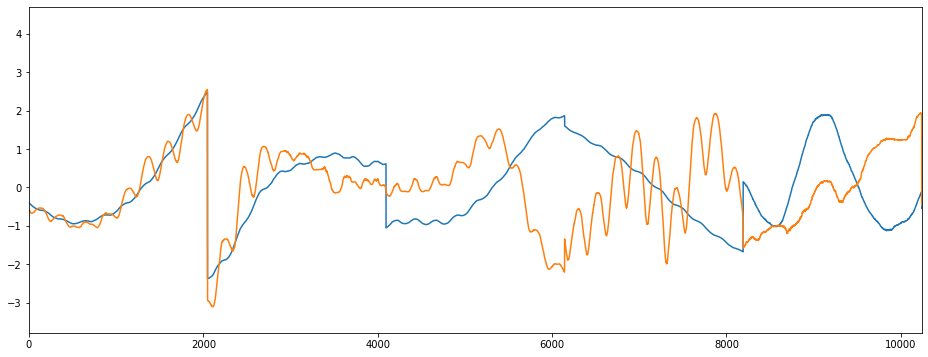

In [33]:
generator = ObsBoxGenerator(meta_df,
                            n_bunches=2,
                            sequence_length=2048,
                            shuffle=True,
                            seed=42,
                            normalization='znorm',
                            normalization_pre_split=False,
                            abs_diff=False,
                            diff=False,
                            rolling_avg=True,
                            rolling_std=True,
                            rolling_window=2048 + 1)
data = generator[0][0]
fig = plt.figure(figsize=(16, 6))
plt.plot(np.vstack(data))
plt.xlim(0, 2048*5);

# Testing the metada validity

In [34]:
generator = ObsBoxGenerator(meta_df,
                            n_bunches=2,
                            sequence_length=2048,
                            shuffle=True,
                            seed=42,
                            normalization='znorm',
                            normalization_pre_split=False,
                            abs_diff=False,
                            diff=False,
                            rolling_avg=True,
                            rolling_std=True,
                            rolling_window=2048 + 1,
                            return_meta=True)
data, meta = generator[0]
# fig = plt.figure(figsize=(16, 6))
# plt.plot(np.vstack(data))
# plt.xlim(0, 2048*5);

May/11 21:43:28 pyobsbox.generator DEBUG: Normalization method: <bound method ObsBoxGenerator._znorm of <pyobsbox.generator.ObsBoxGenerator object at 0x7fc5e963fdd8>>
May/11 21:43:28 pyobsbox.generator DEBUG: Normalization kwargs: {}
May/11 21:43:28 pyobsbox.generator DEBUG: Shuffling metadata, seed 42
May/11 21:43:28 pyobsbox.generator INFO: Completed 'batch_size': 62
May/11 21:43:28 pyobsbox.generator INFO: metadata_path: None
May/11 21:43:28 pyobsbox.generator INFO: ts_length: 63488
May/11 21:43:28 pyobsbox.generator INFO: shuffle: True
May/11 21:43:28 pyobsbox.generator INFO: seed: 42
May/11 21:43:28 pyobsbox.generator INFO: batch_size: 62
May/11 21:43:28 pyobsbox.generator INFO: sequence_length: 2048
May/11 21:43:28 pyobsbox.generator INFO: n_bunches: 2
May/11 21:43:28 pyobsbox.generator INFO: __len__: 184814
May/11 21:43:28 pyobsbox.generator INFO: fetched_log_folder: None
May/11 21:43:28 pyobsbox.generator INFO: fetched_log_prefix: 
May/11 21:43:28 pyobsbox.generator INFO: norma

In [35]:
meta.head()

,type,fill,beam,plane,q,date_time,file,n_bunches,bunch_index,bunch_number,ts_length,chunk
61,Inst,6253,1,h,7,2017-09-28 12:58:20,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...,180,81.0,35.0,65536,30
27,Inst,6253,1,h,7,2017-09-28 12:58:20,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...,180,81.0,35.0,65536,13
29,Inst,6253,1,h,7,2017-09-28 12:58:20,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...,180,81.0,35.0,65536,14
59,Inst,6253,1,h,7,2017-09-28 12:58:20,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...,180,81.0,35.0,65536,29
40,Inst,6255,1,h,7,2017-09-29 16:37:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/...,1916,2046.0,1125.0,65536,20


In [36]:
data.shape

(62, 2048, 2)

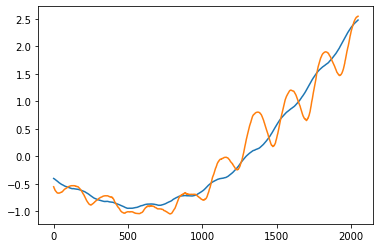

In [37]:
plt.plot(data[0, :])

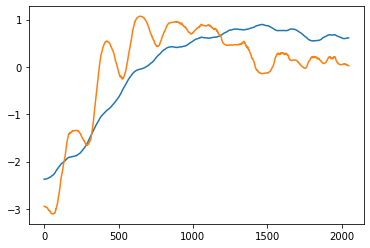

In [38]:
plt.plot(data[1, :])

In [39]:
meta

,type,fill,beam,plane,q,date_time,file,n_bunches,bunch_index,bunch_number,ts_length,chunk
61,Inst,6253,1,h,7,2017-09-28 12:58:20,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...,180,81.0,35.0,65536,30
27,Inst,6253,1,h,7,2017-09-28 12:58:20,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...,180,81.0,35.0,65536,13
29,Inst,6253,1,h,7,2017-09-28 12:58:20,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...,180,81.0,35.0,65536,14
59,Inst,6253,1,h,7,2017-09-28 12:58:20,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...,180,81.0,35.0,65536,29
40,Inst,6255,1,h,7,2017-09-29 16:37:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/...,1916,2046.0,1125.0,65536,20
...,...,...,...,...,...,...,...,...,...,...,...,...
0,Inst,6255,1,h,7,2017-09-29 16:37:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/...,1916,2046.0,1125.0,65536,0
15,Inst,6253,1,h,7,2017-09-28 12:58:20,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...,180,81.0,35.0,65536,7
32,Inst,6255,1,h,7,2017-09-29 16:37:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/...,1916,2046.0,1125.0,65536,16
38,Inst,6255,1,h,7,2017-09-29 16:37:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/...,1916,2046.0,1125.0,65536,19


In [40]:
generator = ObsBoxGenerator(meta_df,
                            n_bunches=2,
                            sequence_length=2048,
                            shuffle=True,
                            seed=42,
                            normalization='raw',
                            normalization_pre_split=False,
                            abs_diff=False,
                            diff=False,
                            rolling_avg=True,
                            rolling_std=False,
                            rolling_window=512 + 1,
                            return_meta=True)
data, meta = generator[0]

May/11 21:43:29 pyobsbox.generator DEBUG: Normalization method: <function ObsBoxGenerator.__init__.<locals>.<lambda> at 0x7fc5e95e88c8>
May/11 21:43:29 pyobsbox.generator DEBUG: Normalization kwargs: {}
May/11 21:43:29 pyobsbox.generator DEBUG: Shuffling metadata, seed 42
May/11 21:43:29 pyobsbox.generator INFO: Completed 'batch_size': 62
May/11 21:43:29 pyobsbox.generator INFO: metadata_path: None
May/11 21:43:29 pyobsbox.generator INFO: ts_length: 63488
May/11 21:43:29 pyobsbox.generator INFO: shuffle: True
May/11 21:43:29 pyobsbox.generator INFO: seed: 42
May/11 21:43:29 pyobsbox.generator INFO: batch_size: 62
May/11 21:43:29 pyobsbox.generator INFO: sequence_length: 2048
May/11 21:43:29 pyobsbox.generator INFO: n_bunches: 2
May/11 21:43:29 pyobsbox.generator INFO: __len__: 184814
May/11 21:43:29 pyobsbox.generator INFO: fetched_log_folder: None
May/11 21:43:29 pyobsbox.generator INFO: fetched_log_prefix: 
May/11 21:43:29 pyobsbox.generator INFO: normalization: raw
May/11 21:43:29 p

In [41]:
meta.head()

,type,fill,beam,plane,q,date_time,file,n_bunches,bunch_index,bunch_number,ts_length,chunk
61,Inst,6253,1,h,7,2017-09-28 12:58:20,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...,180,81.0,35.0,65536,30
27,Inst,6253,1,h,7,2017-09-28 12:58:20,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...,180,81.0,35.0,65536,13
29,Inst,6253,1,h,7,2017-09-28 12:58:20,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...,180,81.0,35.0,65536,14
59,Inst,6253,1,h,7,2017-09-28 12:58:20,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...,180,81.0,35.0,65536,29
40,Inst,6255,1,h,7,2017-09-29 16:37:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/...,1916,2046.0,1125.0,65536,20


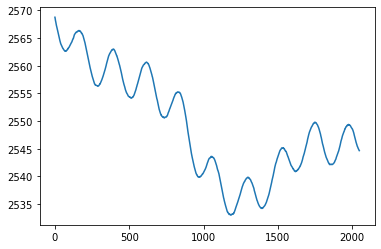

In [42]:
plt.plot(data[0,:])

In [43]:
meta.iloc[0]

type                                                         Inst
fill                                                         6253
beam                                                            1
plane                                                           h
q                                                               7
date_time                                     2017-09-28 12:58:20
file            /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...
n_bunches                                                     180
bunch_index                                                    81
bunch_number                                                   35
ts_length                                                   65536
chunk                                                          30
Name: 61, dtype: object

In [44]:
meta = meta.reset_index()
next_chunk_meta = meta[(meta['file'] == meta.iloc[0]['file']) & (meta['chunk'] == meta.iloc[0]['chunk'] - 1)]
next_chunk_meta

,index,type,fill,beam,plane,q,date_time,file,n_bunches,bunch_index,bunch_number,ts_length,chunk
3,59,Inst,6253,1,h,7,2017-09-28 12:58:20,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...,180,81.0,35.0,65536,29


In [45]:
next_chunk_meta.index

Int64Index([3], dtype='int64')

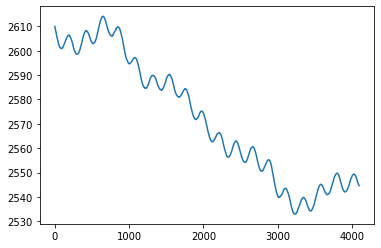

In [46]:
consecutives = np.vstack([data[next_chunk_meta.index[0],:], data[0,:]])
plt.plot(consecutives)

In [47]:
meta.iloc[next_chunk_meta.index[0]]

index                                                          59
type                                                         Inst
fill                                                         6253
beam                                                            1
plane                                                           h
q                                                               7
date_time                                     2017-09-28 12:58:20
file            /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/...
n_bunches                                                     180
bunch_index                                                    81
bunch_number                                                   35
ts_length                                                   65536
chunk                                                          29
Name: 3, dtype: object

Checking to see if it matches with the real data

In [48]:
from pyobsbox.utils import H5_PLANE_KEY
import h5py

def load_h5_bunch(metadata_row: pd.Series):
    
    beam_key = "B{}".format(metadata_row["beam"])
    plane_key = H5_PLANE_KEY[metadata_row["plane"]]
    with h5py.File(metadata_row['file'], "r") as h5_file:
        ob_data = h5_file[beam_key][plane_key]
        print(ob_data.shape)
        return ob_data[:, metadata_row['bunch_index']]
#         fig, ax = plt.subplots(figsize=(16, 6))
#         ax.plot(ob_data[:, bunch_index])

In [49]:
h5_data = load_h5_bunch(meta.iloc[0])
h5_data.shape

(65536, 3564)


(65536,)

(59392.0, 65536.0)

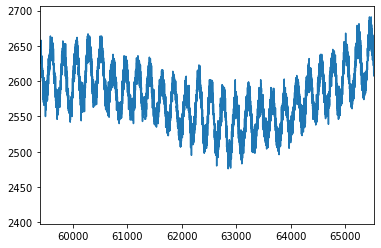

In [50]:
# %matplotlib notebook
plt.plot(h5_data)
plt.xlim([(meta['chunk'].iloc[0] - 1) * generator.sequence_length,
          (meta['chunk'].iloc[0] + 2) * generator.sequence_length])

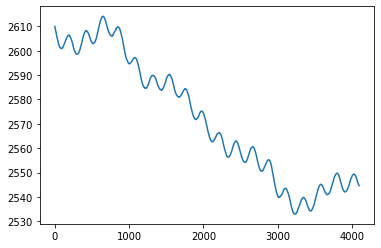

In [51]:
plt.figure()
plt.plot(consecutives)

In [52]:
data_t = data.swapaxes(-1, 1)
data_t_t = rolling_window(data_t, 32)
print(data_t_t.shape)
print(np.shares_memory(data_t_t, data_t))
data_t_t = data_t_t.reshape(-1, data_t.shape[1], 32, order='C')
print(data_t_t.shape)
print(np.shares_memory(data_t_t, data_t))
# data_t.shape = (-1, data_t.shape[1], 32)
data_t_t = data_t_t.swapaxes(-1, 1)
print(data_t_t.shape)
print(np.shares_memory(data_t_t, data_t))

(62, 1, 2017, 32)
True
(125054, 1, 32)
False
(125054, 32, 1)
False


In [53]:
data_t.is

SyntaxError: invalid syntax (<ipython-input-53-df002e3600c9>, line 1)

In [ ]:
plt.plot(np.vstack(data_t_t[:2]))

# Return rolling window 

In [ ]:
generator = ObsBoxGenerator(meta_df,
                            n_bunches=256,
                            sequence_length=2048,
                            shuffle=True,
                            seed=42,
                            normalization='raw',
                            normalization_pre_split=False,
                            abs_diff=False,
                            diff=False,
                            rolling_avg=True,
                            rolling_std=False,
                            rolling_window=512 + 1,
                            return_meta=True,
                            return_window_size=32)
data, meta = generator[0]

In [ ]:
data.shape

In [ ]:
plt.plot(np.vstack(data[:2]))

In [ ]:
break

# Logging the fetched data

In [ ]:
logging.getLogger("pyobsbox").setLevel(logging.DEBUG)
generator = ObsBoxGenerator(meta_df,
                            n_bunches=1,
                            sequence_length=2048,
                            shuffle=False,
                            normalization='znorm',
                            normalization_pre_split=False,
                            fetched_log_folder='log',
                            fetched_log_prefix='testing')
generator[1]

In [ ]:
generator.cleanup_logs()

In [ ]:
# indices of the fetched data in the metadata dataframe
np.load('log/log_fetched.npy')